## Setup + Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'

In [3]:
!unzip -qo "{dataset_path}" -d "./dataset"

In [4]:
# installing dependencies
!pip install -q "transformers[torch]==4.38.2" accelerate
!pip install -q datasets evaluate

# for augmentations
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [5]:
import os
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from transformers import Trainer, TrainingArguments
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import PIL.Image as Img
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import shutil
import albumentations as A
from uuid import uuid4

## Data Analysis

In [77]:
#del data

In [78]:
data = pd.read_csv('dataset/Training.csv')

In [79]:
data.Image = data.Image.map(lambda x: f'dataset/Training Images/{x}')

In [80]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,MildDemented
1,dataset/Training Images/mildDem1.jpg,MildDemented
2,dataset/Training Images/mildDem10.jpg,MildDemented
3,dataset/Training Images/mildDem100.jpg,MildDemented
4,dataset/Training Images/mildDem101.jpg,MildDemented
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,VeryMildDemented
5117,dataset/Training Images/verymildDem996.jpg,VeryMildDemented
5118,dataset/Training Images/verymildDem997.jpg,VeryMildDemented
5119,dataset/Training Images/verymildDem998.jpg,VeryMildDemented


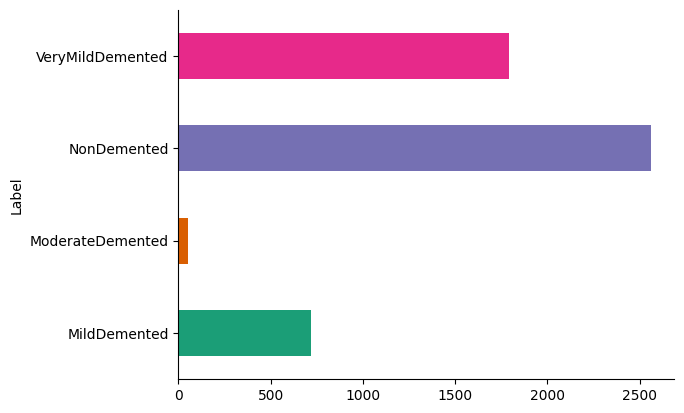

In [81]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Image path: dataset/Training Images/verymildDem1036.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/verymildDem113.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem50.jpg
Label: NonDemented
Image path: dataset/Training Images/verymildDem293.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem1428.jpg
Label: NonDemented
Image path: dataset/Training Images/nonDem1665.jpg
Label: NonDemented


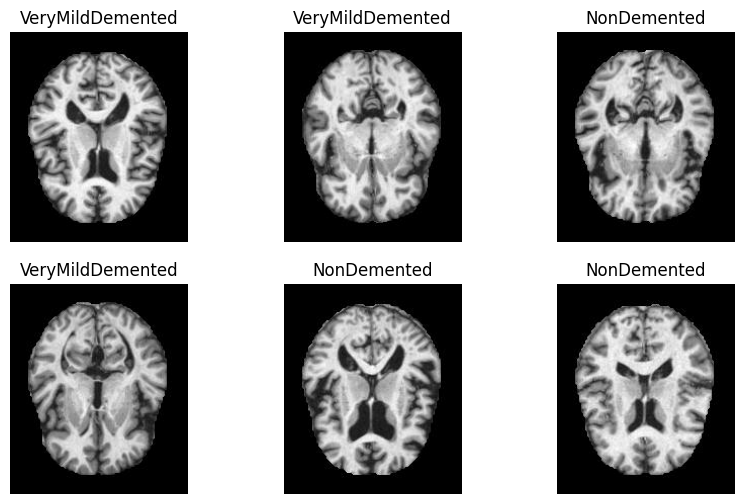

In [82]:

plt.figure(figsize=(10, 6))

for i, idx in enumerate(np.random.choice(len(data), 6)):
    im_path = data.loc[idx, 'Image']  
    label = data.loc[idx, 'Label']    

    print("Image path:", im_path)
    print("Label:", label)


    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Training Setup

In [83]:
id2label = {str(i): c for i, c in enumerate(data.Label.unique())}
label2id = {c: str(i) for i, c in id2label.items()}

id2label

{'0': 'MildDemented',
 '1': 'ModerateDemented',
 '2': 'NonDemented',
 '3': 'VeryMildDemented'}

In [84]:
data.Label = data.Label.map(lambda x: int(label2id[x]))

In [85]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [86]:
image_counts = data['Label'].value_counts()

print(image_counts)

Label
2    2560
3    1792
0     717
1      52
Name: count, dtype: int64


In [87]:
data_limited = pd.DataFrame()  
for label in [2]:
    data_subset = data[data['Label'] == label]
    data_subset_sampled = data_subset.sample(n=1800, random_state=42)
    data_limited = pd.concat([data_limited, data_subset_sampled])

data_other_labels = data[~data['Label'].isin([2])]
data_limited = pd.concat([data_limited, data_other_labels])

In [88]:
data_limited

,Image,Label
2925,dataset/Training Images/nonDem635.jpg,2
2506,dataset/Training Images/nonDem258.jpg,2
1942,dataset/Training Images/nonDem2053.jpg,2
1247,dataset/Training Images/nonDem1428.jpg,2
2125,dataset/Training Images/nonDem2218.jpg,2
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [89]:
image_counts = data_limited['Label'].value_counts()

print(image_counts)

Label
2    1800
3    1792
0     717
1      52
Name: count, dtype: int64


In [90]:
test = pd.DataFrame()
test = data
data = data_limited.reset_index(drop=True)


In [91]:
image_counts = data['Label'].value_counts()

print(image_counts)

Label
2    1800
3    1792
0     717
1      52
Name: count, dtype: int64


In [104]:
import albumentations as A
import cv2
import os
from uuid import uuid4

initial_counts = {
    '2': 2560,  # NonDemented
    '3': 1792,  # VeryMildDemented
    '0': 717,   # MildDemented
    '1': 52     # ModerateDemented
}

target_augmentations = {
    '2': 0,  # NonDemented
    '3': 300,  # VeryMildDemented
    '0': 1500,  # MildDemented
    '1': 1740   # ModerateDemented
}

target_count = 3000

def apply_augmentations(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(p=1),
        A.Rotate(limit=(-180, 180), p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomResizedCrop(height=image.shape[0], width=image.shape[1], p=0.5)
    ])
    return transform(image=image)['image']

!rm -rf augmented_dataset
for id in initial_counts.keys():
    os.makedirs(f'augmented_dataset/{id}', exist_ok=True)

for _, row in data.iterrows():
    img_path, label = row['Image'], row['Label']
    label = str(label)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_name = str(uuid4())
    initial_img_path = f'augmented_dataset/{label}/{img_name}_0.png'
    cv2.imwrite(initial_img_path, img)

    augmentations_needed = target_augmentations[label] // initial_counts[label]
    total_images_created = 1  

    for i in range(augmentations_needed):
        if total_images_created < target_count - initial_counts[label]:
            augmented_img = apply_augmentations(img)
            augmented_img_path = f'augmented_dataset/{label}/{img_name}_{i+1}.png'
            cv2.imwrite(augmented_img_path, augmented_img)
            total_images_created += 1
        else:

            extra_img_path = f'augmented_dataset/{label}/{img_name}_copy_{i+1}.png'
            cv2.imwrite(extra_img_path, img)
            total_images_created += 1
        if total_images_created >= target_count - initial_counts[label]:
            break


In [105]:
import os
augmented_dataset_path = 'augmented_dataset'

image_counts = {}

for label in os.listdir(augmented_dataset_path):
    label_path = os.path.join(augmented_dataset_path, label)
    count = len(os.listdir(label_path))
    image_counts[label] = count

print("Number of images per class in the augmented dataset:")
for label, count in image_counts.items():
    print(f"Label {label}: {count} images")


Number of images per class in the augmented dataset:
Label 1: 1768 images
Label 2: 1800 images
Label 0: 2151 images
Label 3: 1792 images


## Resnet

In [106]:
import torch
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [107]:
def get_transforms(train=True):
    return transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [108]:
dataset = ImageFolder('augmented_dataset', transform=get_transforms())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_val_dataset = ImageFolder('augmented_dataset', transform=get_transforms(train=True))
test_dataset = ImageFolder('dataset/Testing Images', transform=get_transforms(train=False))

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [109]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [111]:
import pandas as pd
import os
import shutil

csv_path = 'dataset/Training.csv'
current_image_dir = 'dataset/Training Images'
output_dir = 'dataset/labels_training'

df = pd.read_csv(csv_path)

os.makedirs(output_dir, exist_ok=True)

for index, row in df.iterrows():
    image_path = os.path.join(current_image_dir, row['Image'])  
    label = row['Label']
    label_dir = os.path.join(output_dir, str(label))

    os.makedirs(label_dir, exist_ok=True)

    new_image_path = os.path.join(label_dir, os.path.basename(image_path))

    shutil.copy(image_path, new_image_path)  

print("Images have been organized into subfolders based on their labels.")


Images have been organized into subfolders based on their labels.


In [112]:
import os

augmented_dataset_path = 'dataset/labels_training'

image_counts = {}

for label in os.listdir(augmented_dataset_path):
    label_path = os.path.join(augmented_dataset_path, label)
    count = len(os.listdir(label_path))
    image_counts[label] = count

print("Number of images per class in the labelled training dataset:")
for label, count in image_counts.items():
    print(f"Label {label}: {count} images")


Number of images per class in the labelled training dataset:
Label MildDemented: 717 images
Label NonDemented: 2560 images
Label ModerateDemented: 52 images
Label VeryMildDemented: 1792 images


In [114]:
import torch.optim as optim
import torch.nn as nn
from torchvision import models

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # Adjust num_classes as needed
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [116]:
num_epochs = 16
for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    print(f'Epoch {epoch+1}: Train Loss: {total_loss / len(train_loader.dataset):.4f}')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss / len(val_loader.dataset):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch 1: Train Loss: 0.2654
Validation Loss: 0.6352, Accuracy: 77.05%
Epoch 2: Train Loss: 0.1381
Validation Loss: 0.2376, Accuracy: 91.75%
Epoch 3: Train Loss: 0.0829
Validation Loss: 0.1821, Accuracy: 93.88%
Epoch 4: Train Loss: 0.0566
Validation Loss: 0.1679, Accuracy: 94.34%
Epoch 5: Train Loss: 0.0431
Validation Loss: 0.2450, Accuracy: 92.95%
Epoch 6: Train Loss: 0.0420
Validation Loss: 0.1448, Accuracy: 94.61%
Epoch 7: Train Loss: 0.0214
Validation Loss: 0.1329, Accuracy: 96.21%
Epoch 8: Train Loss: 0.0166
Validation Loss: 0.0948, Accuracy: 97.07%
Epoch 9: Train Loss: 0.0156
Validation Loss: 0.1041, Accuracy: 96.67%
Epoch 10: Train Loss: 0.0191
Validation Loss: 0.1515, Accuracy: 95.14%
Epoch 11: Train Loss: 0.0207
Validation Loss: 0.1473, Accuracy: 96.21%
Epoch 12: Train Loss: 0.0117
Validation Loss: 0.1747, Accuracy: 95.54%
Epoch 13: Train Loss: 0.0107
Validation Loss: 0.1291, Accuracy: 96.14%
Epoch 14: Train Loss: 0.0070
Validation Loss: 0.1185, Accuracy: 96.47%
Epoch 15: Train

In [117]:
def get_predictions(model, data_loader):
    model.eval()  
    predictions = []
    actual_labels = []
    with torch.no_grad(): 
        for images, labels in data_loader:
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  
            predictions.extend(preds.cpu().numpy())  
            actual_labels.extend(labels.cpu().numpy())  
    return actual_labels, predictions


In [118]:
from sklearn.metrics import classification_report

labels, preds = get_predictions(model, test_loader)
print(classification_report(labels, preds, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']))  # Adjust class names as needed


                  precision    recall  f1-score   support

    MildDemented       0.86      0.46      0.60       179
ModerateDemented       1.00      0.75      0.86        12
     NonDemented       0.79      0.86      0.82       640
VeryMildDemented       0.72      0.77      0.75       448

        accuracy                           0.77      1279
       macro avg       0.84      0.71      0.76      1279
    weighted avg       0.78      0.77      0.76      1279



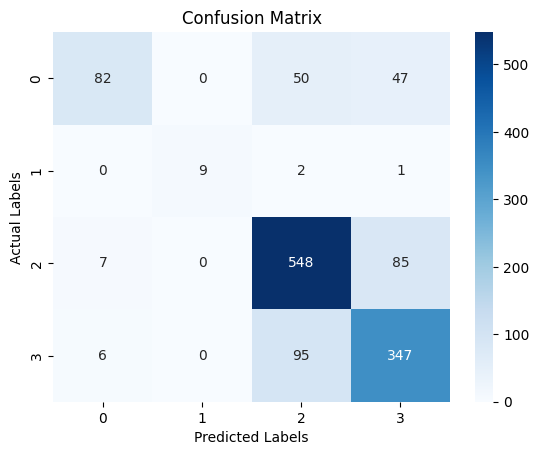

In [119]:
conf_matrix = confusion_matrix(labels, preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


In [120]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI Project/resnet50_v4_16.pth')